# Get data and imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
sns.set()
sns.set_style("darkgrid", {'image.cmap': u'plasma'})

np.random.seed(11111111)

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

--2023-03-02 19:13:13--  https://lazyprogrammer.me/course_files/sp500sub.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 2606:4700:3031::6815:17d2, 2606:4700:3030::ac43:d5a6, 104.21.23.210, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|2606:4700:3031::6815:17d2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473876 (24M) [text/csv]
Saving to: 'sp500sub.csv'

sp500sub.csv        100%[===================>]  24.29M  6.13MB/s    in 5.2s    

2023-03-02 19:13:19 (4.68 MB/s) - 'sp500sub.csv' saved [25473876/25473876]



In [3]:
# read the data
df = pd.read_csv('sp500sub.csv', index_col=0, parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [4]:
df.Name.unique() # get the unique names of the stocks in the data set

array(['INCY', 'GILD', 'DXC', 'AFL', 'XYL', 'ARE', 'AMD', 'WYNN', 'IBM',
       'ATVI', 'AES', 'GPC', 'PRU', 'HST', 'WMB', 'GOOG', 'SRE', 'HSIC',
       'UNP', 'UPS', 'K', 'LYB', 'MDT', 'COF', 'HAS', 'CSX', 'GT', 'SYF',
       'EBAY', 'KSS', 'AJG', 'JWN', 'SBUX', 'IT', 'PH', 'DVN', 'MMM',
       'SPG', 'AKAM', 'IP', 'CPB', 'KMI', 'AAPL', 'NEM', 'KMX', 'TSCO',
       'SYY', 'VNO', 'NWS', 'NBL', 'ACN', 'APH', 'PDCO', 'WLTW', 'FIS',
       'URI', 'CBOE', 'FISV', 'BA', 'UAA', 'CVS', 'WU', 'SLB', 'AIV',
       'VLO', 'MU', 'CAH', 'AZO', 'CCI', 'ZTS', 'MCO', 'ALLE', 'RHI',
       'UAL', 'IR', 'CB', 'VMC', 'GD', 'AAP', 'NEE', 'ABT', 'WFC', 'DIS',
       'SNA', 'MAR', 'JPM', 'CLX', 'KIM', 'SCG', 'HBI', 'ABBV', 'RSG',
       'ETR', 'ADBE', 'COO', 'HLT', 'INTU', 'SLG', 'GWW', 'COG', 'CBS',
       'FB', 'CMS', 'MDLZ'], dtype=object)

In [38]:
# crete a new dataframe with the closing prices of the stocks to put all the data side by side in one dataframe
names = ['GOOG', 'SBUX', 'KSS', 'NEM']
# look at the returns only over a 6-months period
all_dates = df.index.unique().sort_values()
start_date = all_dates.get_loc('2014-01-02')
end_date = all_dates.get_loc('2014-06-30')
dates = all_dates[start_date:end_date+1]
del start_date, end_date, all_dates
# get the close prices of the stocks
close_prices = pd.DataFrame(index=dates)
tmp1 = df.loc[dates]
for name in names:
    df_temp = tmp1[tmp1.Name == name]
    df_temp = df_temp[['Close']]
    close_prices = close_prices.join(df_temp)
    close_prices = close_prices.rename(columns={'Close': name})

In [39]:
close_prices.head()

,GOOG,SBUX,KSS,NEM
Date,,,,
2014-01-02,554.481689,38.584999,56.990002,23.959999
2014-01-03,550.436829,38.474998,56.860001,23.920000
2014-01-06,556.573853,38.084999,56.040001,24.080000
2014-01-07,567.303589,38.605000,56.099998,23.950001
2014-01-08,568.484192,39.014999,55.180000,23.400000


In [41]:
# Check for nan values and forward fill them
if close_prices.isnull().values.any():
    print('There are nan values in the data set')
    close_prices = close_prices.fillna(method='ffill')
    close_prices = close_prices.fillna(method='bfill')
else:
    print('There are no nan values in the data set')

There are no nan values in the data set


In [42]:
# Create returns dataframe
returns = pd.DataFrame(index=dates[1:])
for name in names:
    returns[name] = close_prices[name].pct_change()[1:] * 100 # get the returns of the stocks in percentage

In [43]:
returns.head()

,GOOG,SBUX,KSS,NEM
Date,,,,
2014-01-03,-0.729485,-0.285086,-0.228112,-0.166941
2014-01-06,1.114937,-1.013644,-1.442138,0.668896
2014-01-07,1.927819,1.365368,0.107062,-0.539864
2014-01-08,0.208108,1.062038,-1.639925,-2.296456
2014-01-09,-0.962997,-0.551071,0.688657,-0.854696


In [45]:
mean_return = returns.mean() # get the mean returns of the stocks in the portfolio (in percentage) over the 6-months period
mean_return

GOOG    0.038691
SBUX    0.009955
KSS    -0.053793
NEM     0.072932
dtype: float64

In [48]:
# Calculate the covariance matrix of the returns
cov_matrix = returns.cov()
cov_matrix = cov_matrix.values # convert the covariance matrix to a numpy array to be able to use it in the monte carlo simulation 
cov_matrix

array([[ 2.20656478,  0.832469  ,  0.77177157, -0.03360028],
       [ 0.832469  ,  1.55840635,  0.71458628,  0.37444817],
       [ 0.77177157,  0.71458628,  2.02585403,  0.18030838],
       [-0.03360028,  0.37444817,  0.18030838,  4.81510393]])

# Run Monte Carlo Simulation allowing short selling

In [49]:
def plot_portfolios(returns, risks):
    """Plot the returns and risks of the portfolios.
    Draw a scatter plot of the returns and the risks of the portfolios
    The color of the points is determined by the density of the points
    """
    plt.figure(figsize=(10, 6))
    xy = np.vstack([risks,returns])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    risks, returns, z = risks[idx], returns[idx], z[idx]
    plt.scatter(risks, returns, c=z, marker='o')
    plt.xlabel('Risk')
    plt.ylabel('Return')

Text(0.5, 1.0, 'Markowitz Bullet')

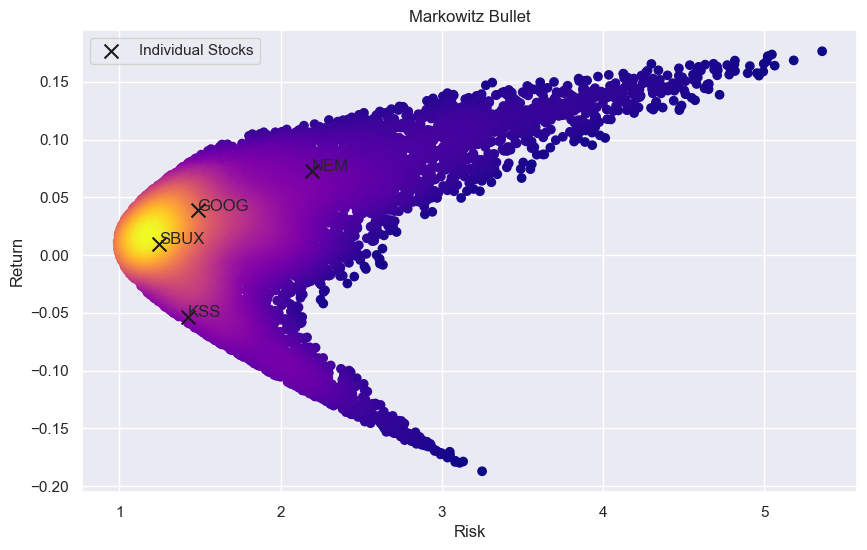

In [57]:
N = 10000 # number of simulations
D = len(names) # number of stocks in the portfolio
returns_array = np.zeros(N) # create an array to store the average returns of the stocks in the portfolio for each simulation
risks_array = np.zeros(N) # create an array to store the average risks of the stocks in the portfolio for each simulation
random_weights = [] # create an array to store the random weights of the stocks in the portfolio for each simulation
for i in range(N):
    rand_range = 1 # set the range of the random numbers to be between 0 and 1
    w = np.random.random(D) * rand_range - rand_range/2 # generate random weights for the stocks in the portfolio (between -0.5 and 0.5)
    w[-1] = 1 - np.sum(w[:-1]) # make sure that the sum of the weights is 1
    np.random.shuffle(w) # shuffle the weights to make sure that the weights are not in the same order as the stocks in the portfolio 
    random_weights.append(w) # append the weights to the array
    returns_array[i] = np.dot(w, mean_return) # calculate the average returns of the stocks in the portfolio for each simulation
    risks_array[i] = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))) # calculate the average risks of the stocks in the portfolio for each simulation

single_asset_returns = np.zeros(D) # create an array to store the average returns of the stocks in the portfolio for each simulation
single_asset_risks = np.zeros(D) # create an array to store the average risks of the stocks in the portfolio for each simulation

for i in range(D):
    single_asset_returns[i] = mean_return[i]
    single_asset_risks[i] = np.sqrt(cov_matrix[i,i])

plot_portfolios(returns_array, risks_array)
plt.scatter(single_asset_risks, single_asset_returns, c='k', marker='x', s=100, label='Individual Stocks')
# add labels to the points
for i in range(D):
    plt.annotate(names[i], (single_asset_risks[i], single_asset_returns[i]))
plt.legend()
plt.title('Markowitz Bullet')

# Finding Maximum and Minimum with a Linear Program (LP)

In [58]:
from scipy.optimize import linprog

In [62]:
D = len(names) # number of stocks in the portfolio
A_eq = np.ones((1, D)) # create the equality constraint matrix
b_eq = np.ones(1) # create the equality constraint vector
bounds = tuple((-0.5, None) for x in range(D)) # set the bounds of the weights to be between -0.5 and no upper bound
print(A_eq, b_eq, bounds)

[[1. 1. 1. 1.]] [1.] ((-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None))


In [66]:
# minimize the risk of the portfolio
res = linprog(mean_return, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
min_return = res.fun
res

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -0.1952725235483168
              x: [-5.000e-01 -5.000e-01  2.500e+00 -5.000e-01]
            nit: 0
          lower:  residual: [ 0.000e+00  0.000e+00  3.000e+00  0.000e+00]
                 marginals: [ 9.248e-02  6.375e-02  0.000e+00  1.267e-01]
          upper:  residual: [       inf        inf        inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [-5.379e-02]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

In [67]:
res = linprog(-mean_return, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
max_return = -res.fun
res

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -0.18490322425695138
              x: [-5.000e-01 -5.000e-01 -5.000e-01  2.500e+00]
            nit: 0
          lower:  residual: [ 0.000e+00  0.000e+00  0.000e+00  3.000e+00]
                 marginals: [ 3.424e-02  6.298e-02  1.267e-01  0.000e+00]
          upper:  residual: [       inf        inf        inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [-7.293e-02]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

In [68]:
print(min_return, max_return)

-0.1952725235483168 0.18490322425695138
